# Training Data Generation

This notebook guides you through the training dataset generation process for the BraTS2023 Inpaining Challenge. Feel free to modify and extend the procedure to your liking. For more in-depth modifications, also look at ```include.py``` where the underlying functions are defined.

*Notebook runtime:* Roughly 40 minutes on 16 cores.


## Section Overview

- **Imports and Parameters**:   
    In this section, python libraries are imported and script-wide parameters are set. Most importantly, the local path to the [BraTS 2023 GLI training dataset](https://www.synapse.org/#!Synapse:syn51514105) is specified.
  
  
- **Binarize Existing Masks**:  
    The existing multi-label BraTS 2023 GLI segmentation masks are binarized and post-processed.
  
  
- **Extract Isolated Tumor Segmentations**:  
    Connected segmentation compartments are extracted from the binarized masks. 
  
  
- **Generate Healthy Tissue Masks**:  
    The previously extracted pool of tumor segmentation compartments is used as pool to sample healthy tissue segmentation masks. Healthy mask candidates are semi-randomly chosen and placed in the existing brain.


*Note:* For more details on the healthy mask generation process see [section 2.2
"Healthy Inpainting Mask Generation"](https://arxiv.org/abs/2305.08992) of our challenge manuscript.

## Imports and Parameters

In [1]:
# Install required libraries (uncomment to make effective)
# %pip install numpy pandas nibabel scipy tqdm

# Includes all the relevant libraries and function we use in this notebook
from include import *
import matplotlib.pyplot as plt  # for figures in this notebook

In [2]:
# Input Folder (the unpacked ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData.zip)
inputFolderRoot = Path("../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/")
assert (
    inputFolderRoot.exists()
)  # check existence of folder. If this assertion fails, you might need to download and extract https://www.synapse.org/#!Synapse:syn51514132

# Randomness
seed = 2023
np.random.seed(seed)

# Multi-Processing
threads = 16  # how many sub-processes shall be used

# Output Folder
outputFolderRoot = Path("../ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training/")

## Binarize Existing Masks

We take the original BraTS segmentation masks and return a table of binary segmentation mask.

The binary segmentation masks can be cleaned/post-processed (segmentationMinSize, fillHoles). Also, results are stored in the current working directory ("binarySegmentationMasks.gz") so they do not have to be recomputed when this notebook is re-run.
            

In [3]:
tumorSegmentations = generateBinarySegmentationMasks(  # Runtime: ~8 minutes on 16 cores
    inputFolderRoot=inputFolderRoot, relevantLabels=[1, 2, 3], segmentationMinSize=800, fillHoles=True, forceRefresh=False, threads=threads
)

Processing 1251 folders from ../ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData.


100%|██████████| 1251/1251 [06:14<00:00,  3.34it/s]


Saving data to binarySegmentationMasks.gz


Arguments of generateBinarySegmentationMasks:
- **inputFolderRoot** : pathlib.Path  
    Example:"ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"


- **relevantLabels** : list, optional, default=[1,2,3]  
    List of original BraTS labels that will be considered for the "whole tumor" annotation. This variable
    relates to the labels in segmentationMask.
    
    
- **segmentationMinSize** : int, optional, default=800  
    All binary segmentation compartments below this size (in voxels) will be not be considered/returned.
    
    
- **fillHoles** : bool, optional, default=True  
    If True, fills holes in the 3D binary segmentation mask (if there are any), otherwise does nothing.
    
    
- **forceRefresh** : bool, optional, default=False  
    If True, (re)creates the *binarySegmentationMasks.gz* file, which stores the resulting binary segmentation masks.
    If False and *binarySegmentationMasks.gz* already exists, then the returned DataFrame is taken from the 
    results file. If the results file does not exist, it is generated (as if forceRefresh was True).

In [4]:
tumorSegmentations.head()

,brainMask,brainMask_V,tumorSegmentation,tumorSegmentation_p
brainFolder,,,,
BraTS-GLI-00000-000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1480170,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.038615
BraTS-GLI-00002-000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1392393,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.136905
BraTS-GLI-00003-000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1617263,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.061363
BraTS-GLI-00005-000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1292500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.096545
BraTS-GLI-00006-000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1519598,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090757


Return values of generateBinarySegmentationMasks():
- **tumorSegmentations** : pandas.DataFrame  
    Table containing all generated binary segmentation masks. The DataFrame has the following columns:
    - **brainFolder** : str, primary key.  
        Folder name of the respective folder in inputFolderRoot.
        
    - **brainMask** : numpy.ndarray  
        The packed (see numpy.packbits()) brain mask. This brain masked is obtained by taking all non-zero
        T1 voxels.
        
    - **brainMask_CoM** : tuple  
        The 3D coordinates of center of mass of the brain mask. 
         
    - **brainMask_V** : numpy.float64
        Volume of brainMask measured in voxels
        
    - **tumorMask** : numpy.ndarray  
        The binary segmentation mask of the "whole tumor".
        
    - **tumorMask_V** : numpy.float64  
        Volume of tumorMask measured in voxels.
        
    - **tumorMask_p** : numpy.float64
        Volume of binarySegmentationMask measured in percentage of the brainMask. 

### Example Figure: Binarized mask

BraTS-GLI-01154-000: tumor segmentation mask


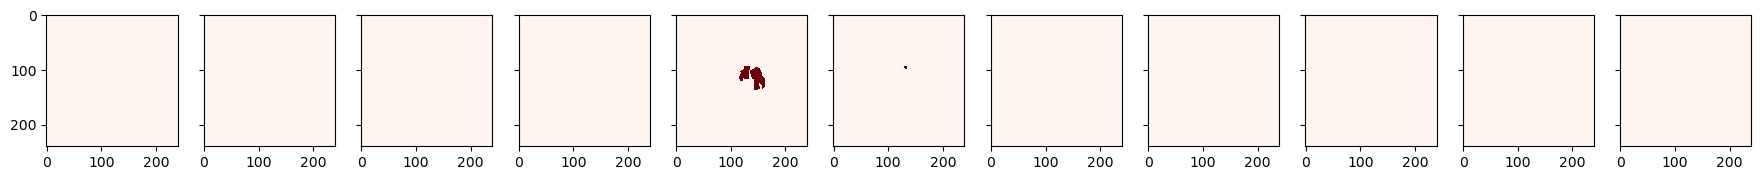

In [5]:
def plot_3D_single(mask, steps_size=15, cmap="gray"):
    shape = mask.shape
    sliceIDs = list(range(0, shape[-1], steps_size))
    size = (shape[0] / 120.0, shape[1] / 120.0)

    fig, ax = plt.subplots(figsize=(size[0] * len(sliceIDs), size[1]), nrows=1, ncols=len(sliceIDs), sharey=True, dpi=100)

    for i, sliceID in enumerate(sliceIDs):
        ax[i].imshow(mask[:, :, sliceID].T, cmap=cmap, interpolation="nearest")
        # ax[i].set_title(sliceID)

    plt.show()


# choose random segmentation mask
folderName = np.random.choice(tumorSegmentations.index)  # get random folder

# unpack segmentation mask
packedMask = tumorSegmentations.at[folderName, "tumorSegmentation"]  # get packed mask
tumorSegmentation = np.unpackbits(packedMask).reshape(niftiShape).astype(bool)  # unpack mask

# plot
print(f"{folderName}: tumor segmentation mask")
plot_3D_single(tumorSegmentation, cmap="Reds")

### (Optional) Figure: Binarized masks distribution

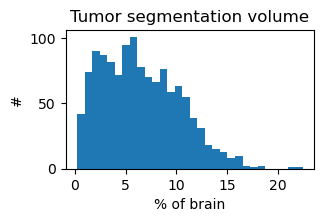

In [6]:
plt.figure(figsize=(1.6 * 2, 0.9 * 2))
plt.title("Tumor segmentation volume")
plt.hist(tumorSegmentations.tumorSegmentation_p * 100, bins=30)
plt.xlabel("% of brain")
plt.ylabel("#")
plt.show()

## Extract Isolated Tumor Segmentations

We take the previously generated binary segmentation masks and extract all isolated segmentation compartments.

For each brain, connected components of tumor segmentations are found and a separate crop for each of these components (tumorCompartments) is returned.

In [7]:
tumorCompartments = getTumorCompartments(tumorSegmentations, forceRefresh=False, threads=threads)  # takes ~1.5 minutes on 16 cores

print(f"Extracted {len(tumorCompartments.index)} segmentation compartments from {len(tumorSegmentations.index)} brains")

100%|██████████| 1251/1251 [01:36<00:00, 13.01it/s]


Saving data to tumorCompartments.gz
Extracted 1429 segementation compartements from 1251 brains


Arguments for getSegmentationCompartments:
- **tumorSegmentations** : pandas.DataFrame  
    Table containing all binary brain tumor segmentations (see previous section)
- **forceRefresh** : Same effect as in previous section, but filename is *tumorCompartments.gz*
- **threads** : Same effect as in previous section

In [8]:
tumorCompartments.head()

,brainFolder,p,packedCompartment,compartmentShape
0,BraTS-GLI-00000-000,0.038615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(46, 76, 47)"
1,BraTS-GLI-00002-000,0.136905,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(77, 103, 86)"
2,BraTS-GLI-00003-000,0.061363,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(53, 72, 60)"
3,BraTS-GLI-00005-000,0.096545,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(71, 87, 65)"
4,BraTS-GLI-00006-000,0.090757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(75, 71, 68)"


Return values of getSegmentationCompartments():
- **tumorCompartments** : pandas.DataFrame  
     Table containing all extracted tumor segmentation compartments. The DataFrame has the following columns:
    - **brainFolder** : str, primary key.  
        Folder name identifying the brain the compartment was taken from.
    - **p** : numpy.float64  
        Column of the segmentation component size measured in percent of the brainMask.
    - **packedCompartment** : numpy.ndarray, variable shape  
        The segmentation compartment cropped from the whole brain (based on the minimal bounding box).
        As the size of this crop can vary in size, this packed representation also varies in size.
    - **compartmentShape** : list of tuples  
        The shape of the segmentation compartment before it was packed (this is important for unpacking)

### Figure: Example segmentation compartment

BraTS-GLI-00518-001: One tumor segmentation compartment with shape: (49, 67, 53)


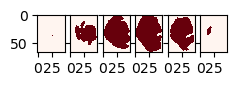

In [9]:
# choose random compartment
index = np.random.choice(tumorCompartments.index)

# unpack segmentation mask
packedComp = tumorCompartments.at[index, "packedCompartment"]  # get packed mask
shape = tumorCompartments.at[index, "compartmentShape"]  # get packed mask
unpacked_length = shape[0] * shape[1] * shape[2]
compartment = np.unpackbits(packedComp)[:unpacked_length].reshape(shape).astype(bool)  # unpack mask

# plot
print(f"{tumorCompartments.at[index, 'brainFolder']}: One tumor segmentation compartment with shape: {shape}")
plot_3D_single(compartment, steps_size=10, cmap="Reds")

### Figure: Compartment pool size distribution

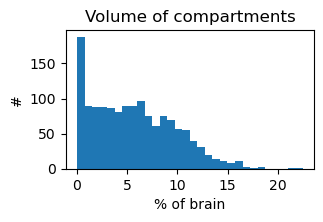

In [10]:
plt.figure(figsize=(1.6 * 2, 0.9 * 2))
plt.title("Volume of compartments")
plt.hist(tumorCompartments.p * 100, bins=30)
plt.xlabel("% of brain")
plt.ylabel("#")
plt.show()

## Generate Healthy Tissue Masks

Healthy tissue masks are generated by taking an existing tumor masks and placing them in healthy regions.

For that, tumor masks are semi-randomly sampled from the existing segmentation pool (tumorCompartments). They are transformed and semi-randomly placed in the brain. Potentially resampling is required until the placement configuration fulfills the specified quality requirements.


In [11]:
healthyMasks = getHealthyMasks(  # takes ~30 minutes on 16 cores
    inputFolderRoot,
    outputFolderRoot,
    tumorSegmentations,
    tumorCompartments,
    samplesPerBrain=1,  # This you want to increase to get more training data
    tumorDilationDistance=5,
    minDistanceToTumor=5.0,
    sizeRangeTolerance=0.1,
    randPointsN=2,
    minimalBrainIntersection_p=0.75,
    forceRefresh=False,
    threads=threads,
    seed=seed,
)

100%|██████████| 1251/1251 [27:42<00:00,  1.33s/it]


Saving data to healthyMasks.gz


Arguments for getHealthyMasks:
- **inputFolderRoot** : pathlib.Path  
    Path to reference BraTS dataset.
    Example:"ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"
    
    
- **outputFolderRoot** : pathlib.Path  
    Path to the output folder. Example: "ASNR-MICCAI-BraTS2023-Local-Synthesis-Challenge-Training"
    
    
- **tumorSegmentations** : pandas.DataFrame  
    Table containing all generated binary segmentation masks.
    For more details see generateBinarySegmentationMasks()
    
    
- **tumorCompartments** : pandas.DataFrame  
    Table containing all extracted tumor segmentation compartments. For mor details see getTumorCompartments()
    
    
- **samplesPerBrain** : int, optional, default=1  
    How many healthy masks shall be sampled per brain. This parameter significantly influences the size of the
    resulting training set.
    
    
- **tumorDilationDistance** : float, optional, default=5.0  
    How much voxels the binary segmentation mask shall be dilated (inflated). This operation makes the tumor
    segmentation bigger and also has a smoothing effect.
    
    
- **minDistanceToTumor** : float, optional, default=5.0  
    Minimal distance the sampled healthy tissue compartment needs to have to the (dilated) tumor mask.
    
    
- **sizeRangeTolerance** : float, optional, default=0.1  
    Percentage of tolerance window for sampling inversely proportional in the compartment size
    distribution. For more details see sampleCompartment()
    
    
- **randPointsN** : int, optional, default=0.1  
    Amount of points to be sampled for choosing the best one. The more points are sampled the
    stronger is the tendency away from the tumor.
    
    
- **minimalBrainIntersection_p** : float, optional, default=0.75  
    How much percentage the compartment has to overlap at least with the brain (brainMask).
    
    
- **forceRefresh** : bool, optional, default=False  
    If True, (re)creates the samples in outputFolderRoot and *healthyMasks.gz*, which stores the resulting
    healthy masks too. If False and *healthyMasks.gz* already exists, then the returned DataFrame is taken
    from the results file. No samples will be (re)generated. If the output folder or the results file does
    not exist, both are generated as if forceRefresh was True.
    
    
- **threads** : int, optional, default=16  
    The amount of parallel sub-processes to compute results.
    
    
- **seed** : int, optional, default=2023  
    Seed to make the sampling process reproducible.

In [12]:
healthyMasks.head()

,packedMasks
brainFolder,
BraTS-GLI-00000-000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
BraTS-GLI-00002-000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
BraTS-GLI-00003-000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
BraTS-GLI-00005-000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
BraTS-GLI-00006-000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Return values of getHealthyMasks():
- **healthyMasks** : pandas.DataFrame  
    Table containing all extracted tumor segmentation compartments. The DataFrame has the following columns:
    - **brainFolder** : str, primary key.  
        Folder name identifying the brain the healthy mask(s) was/were generated for.
    - **packedMasks** : list of numpy.ndarray of shape: (240x240x155)/8 = 1116000  
        A list of packed (see numpy.packbits()) healthy tissue masks that were generated for the respective brain.
        The length of this list is equal to samplesPerBrain.

### Figure: Example mask

BraTS-GLI-00757-000: t1n


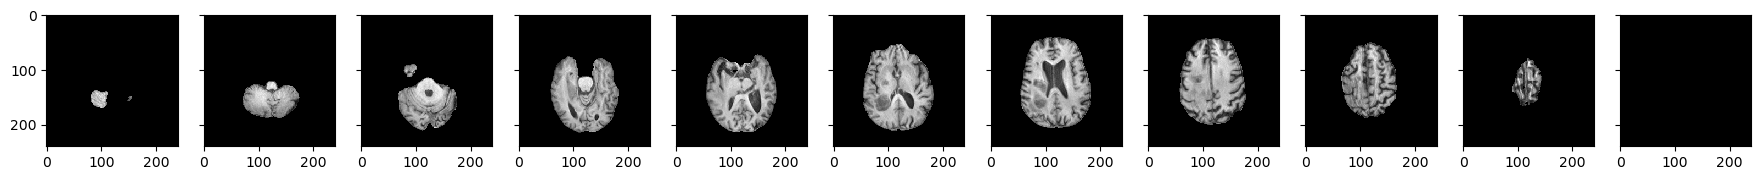

BraTS-GLI-00757-000: mask-unhealthy


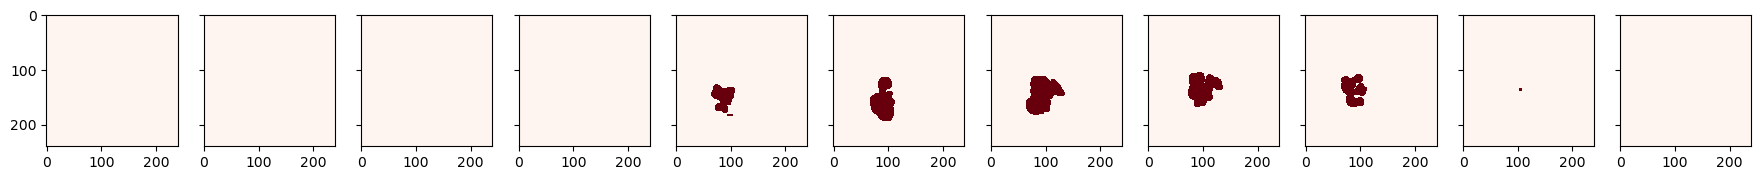

BraTS-GLI-00757-000: mask-healthy


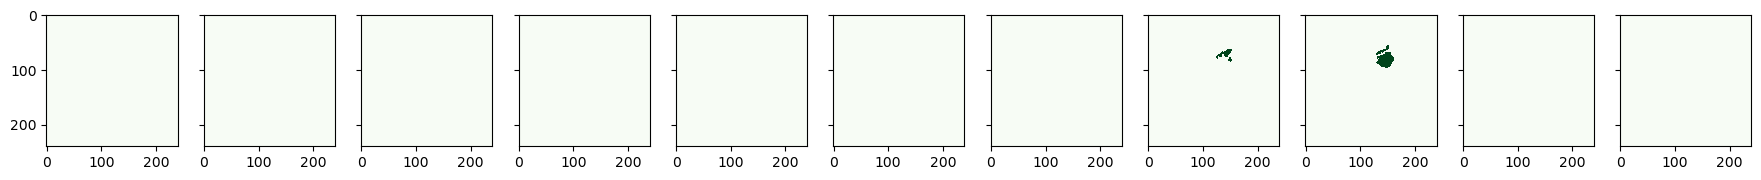

In [13]:
# choose random healthy mask
folderName = np.random.choice(healthyMasks.index)  # get random folder

# plot t1n
print(f"{folderName}: t1n")
filePath = outputFolderRoot.joinpath(folderName).joinpath(f"{folderName}-t1n.nii.gz")
t1n = nib.load(filePath).get_fdata()
plot_3D_single(t1n)

# plot unhealthy mask
print(f"{folderName}: mask-unhealthy")
filePath = outputFolderRoot.joinpath(folderName).joinpath(f"{folderName}-mask-unhealthy.nii.gz")
unhealthy = nib.load(filePath).get_fdata()
plot_3D_single(unhealthy, cmap="Reds")

# plot healthy mask
print(f"{folderName}: mask-healthy")
packedMask = healthyMasks.at[folderName, "packedMasks"][0]  # take first packed mask
healthy = np.unpackbits(packedMask).reshape(niftiShape).astype(bool)  # unpack mask
plot_3D_single(healthy, cmap="Greens")